# Classificação de Plásticos com CNN (TensorFlow/Keras)


# 0 Instalação e Importação

## 0.1 Instalação

In [1]:
#!pip install tensorflow
#!pip install opendatasets

## 0.2 Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import os
import random

In [3]:
import tensorflow as tf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 CARREGAMENTO DO DATASET

In [5]:
# Caminho do dataset redimensionado (224x224)
base_dir = '../data/Plastic_Classification_224'

In [6]:
#Parâmetros
image_size = (224,224)
batch_size = 32


In [7]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [8]:
# Carregamento do dataset
# Verifique se os rótulos são inteiros
train_ds = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',  # <-- mudar aqui
    shuffle=True,
    seed=42
)

Found 1441 files belonging to 7 classes.


In [9]:
val_ds = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 416 files belonging to 7 classes.


In [10]:
# Normalização
normalization_layer = layers.Rescaling(1./255)

In [11]:
# Aplicar data augmentation e normalização
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# Melhorar performance com prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Número de classes
num_classes = 7

# 2 Construção do modelo CNN simples 

### 🧠 Objetivo da Etapa:
Construir um modelo de rede neural convolucional (CNN) capaz de:

- Extrair padrões visuais importantes (textura, forma, bordas),

- Aprender representações discriminantes para cada tipo de plástico,

- Classificar corretamente entre as 7 classes.

| Camada                     | Função                                                                                     |
| -------------------------- | ------------------------------------------------------------------------------------------ |
| `Conv2D(32, (3,3), relu)`  | Extrai **32 mapas de características** com filtros 3x3. Detecta bordas, texturas           |
| `MaxPooling2D(2,2)`        | Reduz o tamanho das imagens, mantendo os padrões mais fortes (reduz ruído)                 |
| `Conv2D(64, (3,3), relu)`  | Agora detecta **padrões mais complexos**, como formas e partes de objetos                  |
| `MaxPooling2D(2,2)`        | Continua reduzindo a dimensionalidade para evitar overfitting e acelerar treino            |
| `Conv2D(128, (3,3), relu)` | Capta ainda **padrões mais abstratos**, como combinação de partes (ex: logotipo + formato) |
| `MaxPooling2D(2,2)`        | Redução final da resolução antes da parte densa                                            |
| `Flatten()`                | Converte as features 3D extraídas em vetor 1D para a rede densa                            |
| `Dense(128, relu)`         | Camada totalmente conectada com 128 neurônios. Aprende combinações complexas dos padrões   |
| `Dense(7, softmax)`        | Saída final com 7 neurônios (1 por classe). Softmax transforma em probabilidades           |


| Decisão                                            | Justificativa                                                    |
| -------------------------------------------------- | ---------------------------------------------------------------- |
| **Filtros pequenos (3x3)**                         | Captam detalhes finos das imagens, muito usados em CNNs modernas |
| **Pooling 2x2**                                    | Evita overfitting, reduz dimensionalidade e melhora performance  |
| **Aumento progressivo de filtros (32 → 64 → 128)** | Aumenta a complexidade do que o modelo pode aprender             |
| **ReLU**                                           | Evita problemas de saturação, acelera o aprendizado              |
| **Softmax + categorical\_crossentropy**            | Ideal para classificação multiclasse com one-hot encoding        |


In [14]:
# Arquitetura CNN com regularização
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
# Compilar o modelo
# Use loss apropriada para rótulo inteiro
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

### Entendimento:

🧠 O que são parâmetros?

São os pesos e vieses aprendidos automaticamente pelo modelo durante o treinamento, e definem como ele faz previsões.

| Linha                  | Significado                                                                        |
| ---------------------- | ---------------------------------------------------------------------------------- |
| `Total params`         | Todos os parâmetros (pesos + vieses) da rede                                       |
| `Trainable params`     | Parâmetros que serão atualizados pelo otimizador (ex: Adam)                        |
| `Non-trainable params` | Parâmetros congelados (por exemplo, em transfer learning) — **aqui não há nenhum** |


### 📦 Por que temos 11 milhões de parâmetros?

Mesmo com uma CNN simples, ao chegar na camada Flatten e depois Dense(128) + Dense(7), o número de conexões totalmente conectadas cresce rapidamente.

Por exemplo:

Se a última saída da MaxPooling2D for (26, 26, 128), a Flatten() transforma isso em um vetor de 43264 unidades.

- Flatten → Dense(128) = 43264 × 128 + 128 = 5.537.920

- Dense(128) → Dense(7) = 128 × 7 + 7 = 903

Somando com os parâmetros das camadas convolucionais (que também têm muitos filtros), chega-se facilmente aos 11 milhões.

### ⚠️ Isso é muito?

| Caso                                            | Avaliação                                     |
| ----------------------------------------------- | --------------------------------------------- |
| Para uma CNN simples em imagens pequenas        | **Sim, é relativamente grande**               |
| Para modelos complexos como ResNet/EfficientNet | **É pequeno/modesto**                         |
| Para hardware comum (sem GPU)                   | Pode ser **pesado** e lento                   |
| Para aprendizado                                | **Didaticamente bom**, mas pode ser otimizado |


### ✅ Dicas para reduzir parâmetros se necessário:
Usar menos filtros (ex: 16, 32, 64 em vez de 32, 64, 128)

Adicionar uma camada GlobalAveragePooling2D() em vez de Flatten() para evitar explodir o número de conexões

Reduzir a dimensão da imagem de entrada, se aplicável

# 3 Treinar o modelo

In [16]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 540s 12s/step - accuracy: 0.2190 - loss: 23.1292 - val_accuracy: 0.1418 - val_loss: 48.0157
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 605s 13s/step - accuracy: 0.1456 - loss: 1.9947 - val_accuracy: 0.1418 - val_loss: 83.1667
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 736s 16s/step - accuracy: 0.1696 - loss: 1.9150 - val_accuracy: 0.1418 - val_loss: 92.6684
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 634s 13s/step - accuracy: 0.1858 - loss: 1.8658 - val_accuracy: 0.1418 - val_loss: 93.9089
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 619s 13s/step - accuracy: 0.1899 - loss: 1.8640 - val_accuracy: 0.1418 - val_loss: 86.4541
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 727s 16s/step - accuracy: 0.1802 - loss: 1.8653 - val_accuracy: 0.1442 - val_loss: 69.3047
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 871s 19s/step - accuracy: 0.1948 - loss: 1.8425 - val_accuracy: 0.1322 - val_loss: 38.1044
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 865s 19s/step - accuracy: 0.1653 - loss: 1.8565 - val_accu

In [17]:
# Salvar o modelo
model.save("./modelos/modelo_cnn_regularizado_otimizado.keras", include_optimizer= True)


OBservação:
Aplicar técnicas de regularização (Dropout, BatchNormalization).

Otimizar arquitetura ou testar transfer learning (ResNet, EfficientNet etc.).

# 4 Visualização de desempenho

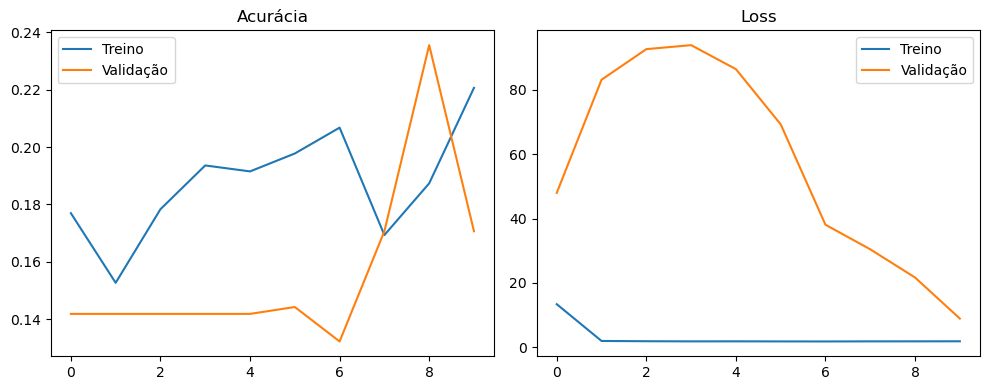

In [18]:
# Plotar gráfico de aprendizado
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()



# 6 Conclusão 

CNN otimizado não está aprendendo de forma eficaz.

### 🔎 Problemas observados
#### 1. 🔻 Baixa Acurácia de Validação:

- Fica entre 12% e 17%, indicando que o modelo não está generalizando.

- Acima de 14% seria apenas sorte para 7 classes (≈14%).

#### 2. 📈 Val Loss crescente:

- A perda de validação sobe drasticamente (de 1.94 para 32.88).

- Sinal clássico de overfitting ou erro de arquitetura.

#### 3. ⏳ Treinamento muito demorado:

- Cerca de 8 a 12 minutos por época sugere que a arquitetura está muito complexa ou mal ajustada para a tarefa.



### 🧠 Possíveis causas

| Categoria        | Problema possível                                           | Solução sugerida                                                         |
| ---------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------ |
| **Rótulos**      | Mismatch entre `label_mode` e `loss` (corrigido?)           | Confirmar se `label_mode='int'` e `loss=SparseCategoricalCrossentropy()` |
| **Base**         | Poucos dados, classe desbalanceada, ou imagens irrelevantes | Ampliar dados com **Data Augmentation**, revisar qualidade das imagens   |
| **Modelo**       | Arquitetura muito rasa ou muito profunda                    | Testar uma arquitetura intermediária com regularização                   |
| **Overfitting**  | Falta de dropout, early stopping ou regularização L2        | Incluir `Dropout`, `BatchNormalization`, `L2` e `EarlyStopping`          |
| **Augmentation** | Augmentation ausente ou pouco eficaz                        | Adicionar `RandomFlip`, `Zoom`, `Rotation` etc.                          |
